# 3D Snake -- Grid-independence study

---

In [1]:
import pathlib
import numpy
from matplotlib import pyplot

from helper import read_forces, get_force_coefficients, get_time_averaged_values

%matplotlib inline

In [2]:
pyplot.rc('font', family='serif', size=16)

We used our in-house research software PetIBM (version [0.2](https://github.com/barbagroup/PetIBM/releases/tag/v0.2)) to perform simulations of the three-dimensional flow around a snake model (a straight cylinder with an anatomically accurate cross-section of the gliding snake *Chrysopelea paradisi*).

PetIBM implements different immersed boundary methods, one of them being the decoupled immersed-boundary projection method from Li et al. (2016).
The method builds on top of the projection method of Perot (1993): an approximate block-LU decomposition of the fully discretized equations for the velocity fluxes, the pressure field, and the Lagrangian forces.

The computational domain is $30c \times 30c \times 3.2c$ ($c$ is the chord-length of the snake cross-section) with the body centered in the $x$/$y$ plane.
We use a fixed structured Cartesian to spatially discretize the domain.
The mesh is uniform in the sub-domain $\left[-0.52c, 3.48c\right]\times\left[-2c, 2c\right]\times\left[0, 3.2c\right]$, which contains the immersed boundary, and stretched to the external boundaries with a constant stretching ratio of $1.01$ in all directions.
The snake cylinder is discretized with the same resolution as the background Eulerian mesh (on which the Navier-Stokes equations are solved).

To assess grid-independence in the aerodynamic forces acting on the immersed body, we performed simulations on two different meshes:

* a "coarse" grid with about $46$ million cells ($1071\times1072\times40$) with a grid-spacing of $0.008c$ in the $x$ and $y$ directions and a grid-spacing of $0.08c$ in the $z$ direction,
* a "fine" grid, generated by halving the grid-spacing in all directions in the uniform sub-domain while maintaining the same stretching ratio outside it. That mesh contains about $233$ million cells ($1074\times1706\times80$).

(Note: a $x$/$z$ slice of the "fine" mesh has the same resolution than the mesh used for two-dimensional simulations of the same cross-section published in Krishnan et al. (2014) and Mesnard & Barba (2017).)

Spatial derivatives are approximated with second-order central differences.
The convective and diffusive terms are integrated in time with an explicit second-order Adams-Bashforth and an implicit second-order Crank-Nicolson schemes, respectively.

The time-step size was respectively set to $0.001$ and $0.0005$ for the "coarse" and "fine" meshes.

The inlet, bottom, and top boundary conditions are set with a uniform velocity of $1$ in the streamwise direction.
We use a linear convective boundary condition at the outlet of the computational domain.
We use periodic boundary conditions in the spanwise $z$-direction.

PetIBM was built with PETSc (version [3.7.4](http://ftp.mcs.anl.gov/pub/petsc/release-snapshots/petsc-lite-3.7.4.tar.gz)) to compute the numerical solution on distributed-memory architectures.
The linear systems for the velocity fluxes and for the Lagrangian boundary forces were solved using a stabilized bi-conjugate gradient method and a GMRES technique, respectively, with a Jacobi preconditioner from PETSc.
Both solvers were configured with an exit criterion based on an absolute tolerance of $10^{-6}$ for the residuals.
The Poisson system was solved on multiple GPU devices with the Nvidia AmgX library using a conjugate-gradient method preconditioned with a classical algebraic multigrid technique.
The exit criterion for the Poisson solver was also based on an absolute tolerance of $10^{-6}$ for the residuals.
To accomodate PETSc data structures with the NVIDIA AmgX library, we used AmgXWrapper.
AmgXWrapper (Chuang & Barba, 2017) is an open-source interface between PETSc and AmgX designed to handle data transfers between CPUs and GPU devices.

## Cloud environment

With the "coarse" grid, we computed $100$ non-dimensional time-units of flow simulation on a single NC24 node of Microsoft Azure ($24$ CPUs and $4$ GPU devices).
The computation was done with PetIBM-0.2, PETSc-3.7.4, OpenMPI-1.8.8, CUDA-6.5, and AmgX-1.2-build108.
At the time of running this simulation, AmgX was only available as a compiled library to Nvidia registered developers coming a free license for non-commercial use.
At the time of writing, AmgX is now an open-source project hosted on [GitHub](https://github.com/NVIDIA/AMGX).

The numerical solution after $100$ time units was then interpolated on the "fine" grid and we restarted the run (halving the time-step size).
The simulation on the "fine" grid ran on $6$ NC24r nodes ($24$ CPUs and $4$ GPU devices per node) using [Azure Batch](https://azure.microsoft.com/en-us/services/batch/) and [Batch Shipyard](https://azure.github.io/batch-shipyard/).
We used CentOS-7 base image with PetIBM-0.2, PETSc-3.7.4, Intel MPI, CUDA-8.0 ,and AmgX-2.0 (source code provided by Nvidia under NDA so we could build the library with Intel MPI).
(The NC24r instance of Microsoft Azure features RMDA connectivity to use InfiniBand network.)
The simulation on the "fine" mesh was restarted twice to maintain the runtime under $7$ days, which was the maximum time limit enforced by Azure for Batch tasks at that time.
(Since then, the maximum time limit has now been extended to $180$ days.)

<center>Table: Cost of the three-dimensional simulations.<\center>

| Run | Grid size | # Time steps | Nodes | Cost (USD) |
|:-:|:-:|:-:|:-:|:-:|
| 3D (coarse) | 46M | 100,000 | 1 NC24 | 586.3 |
| 3D (fine) | 233M | 98,614 | 6 NC24r | 7854.7 |
| 3D (fine, restart 1) | 233M | 55,200 | 6 NC24r | 3424.1 |
| 3D (fine) | 233M | 32,000 | 6 NC24r | 1923.2 |

## History of the force coefficients

The drag and Lift coefficients are defined as

$$
\begin{equation}
	C_D = \frac{F_x}{\frac{1}{2} \rho U_\infty^2 c L_z},\quad C_L = \frac{F_y}{\frac{1}{2} \rho U_\infty^2 c L_z}
\end{equation}
$$

where $F_x$ and $F_y$ are the total forces in the streamwise and cross-flow directions, respectively, $c$ is the chord length of the snake cross-section, and $L_z$ is the spanwise length.

In [3]:
runs_dir = pathlib.Path('.').absolute() / 'runs'  # data directory
runs = {}  # dictionary to store data

# Parameters.
c = 1.0  # chord length
Lz = 3.2 * c  # spanwise length
rho = 1.0  # density
U_inf = 1.0  # freestream speed

# Read the forces from the 3D run (coarse) and get the force coefficients.
filepath = runs_dir / 'snake3d2k35-coarse' / 'forces.txt'
t, fx, fy, _ = read_forces(filepath)
cd, cl = get_force_coefficients(fx, fy, coeff=1 / (0.5 * rho * U_inf * c * Lz))
runs['3D (coarse)'] = dict(t=t, cd=cd, cl=cl)

# Read the forces from the 3D run (fine) and get the force coefficients.
filepaths = [runs_dir / ('snake3d2k35-fine' + ext) / 'forces.txt'
             for ext in ['', '-restart1', '-restart2']]
t, fx, fy, _ = read_forces(*filepaths)
t += 50.0  # apply time correction as time-step size was halved
cd, cl = get_force_coefficients(fx, fy, coeff=1 / (0.5 * rho * U_inf * c * Lz))
runs['3D (fine)'] = dict(t=t, cd=cd, cl=cl)

In [4]:
# Set plotting parameters.
runs['3D (coarse)']['kwargs'] = dict(color='black')
runs['3D (fine)']['kwargs'] = dict(color='C0')

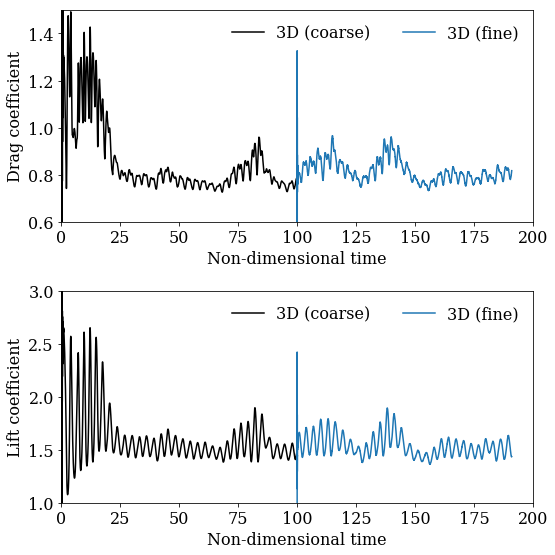

In [5]:
# Plot the history of the drag and lift coefficients.
fig, (ax1, ax2) = pyplot.subplots(nrows=2, figsize=(8.0, 8.0))
ax1.set_xlabel('Non-dimensional time')
ax1.set_ylabel('Drag coefficient')
for label, data in runs.items():
    ax1.plot(data['t'], data['cd'], label=label, **data['kwargs'])
ax1.legend(ncol=3, frameon=False, loc='upper right')
ax1.set_xlim(0.0, 200.0)
ax1.set_ylim(0.6, 1.5)
ax2.set_xlabel('Non-dimensional time')
ax2.set_ylabel('Lift coefficient')
for label, data in runs.items():
    ax2.plot(data['t'], data['cl'], label=label, **data['kwargs'])
ax2.legend(ncol=3, frameon=False, loc='upper right')
ax2.set_xlim(0.0, 200.0)
ax2.set_ylim(1.0, 3.0)
fig.tight_layout()

## Time-averaged force coefficients

With the "coarse" grid, the simulation compute $100$ time units and we average the instantaneous force coefficients between $50$ and $100$ time units.

With the "fine" grid, the simulation started after $100$ time units; we average the aerodynamic coefficients between $100$ and $150$ time units.

In [6]:
# Compute the time-averaged force coefficients for the coarse simulation.
t, cd, cl = (runs['3D (coarse)'][key] for key in ('t', 'cd', 'cl'))
cd_mean_ref, cl_mean_ref = get_time_averaged_values(t, cd, cl, limits=(50.0, 100.0))

# Compute the time-averaged force coefficients for the fine simulation.
t, cd, cl = (runs['3D (fine)'][key] for key in ('t', 'cd', 'cl'))
cd_mean, cl_mean = get_time_averaged_values(t, cd, cl, limits=(100.0, 150.0))

# Print the time-averaged force coefficients.
print('Case\t\t<CD>\t\t<CL>')
print(45 * '-')
# Coarse grid.
label = '3D (coarse)'
print('{}\t{:.4f}\t\t{:.4f}'.format(label, cd_mean_ref, cl_mean_ref))
# Fine grid.
label = '3D (fine)'
cd_rdiff = (cd_mean - cd_mean_ref) / cd_mean_ref * 100.0
cl_rdiff = (cl_mean - cl_mean_ref) / cl_mean_ref * 100.0
print('{}\t{:.4f} ({:.2f}%)\t{:.4f} ({:.2f}%)'
      .format(label, cd_mean, cd_rdiff, cl_mean, cl_rdiff))

Case		<CD>		<CL>
---------------------------------------------
3D (coarse)	0.7882		1.5236
3D (fine)	0.8391 (6.45%)	1.5697 (3.02%)


## References

* Krishnan, A., Socha, J. J., Vlachos, P. P., & Barba, L. A. (2014). Lift and wakes of flying snakes. Physics of Fluids, 26(3), 031901.
* Li, R. Y., Xie, C. M., Huang, W. X., & Xu, C. X. (2016). An efficient immersed boundary projection method for flow over complex/moving boundaries. Computers & Fluids, 140, 122-135.
* Mesnard, O., & Barba, L. A. (2017). Reproducible and replicable computational fluid dynamics: it's harder than you think. Computing in Science & Engineering, 19(4), 44.
* Perot, J. B. (1993). An analysis of the fractional step method. Journal of Computational Physics, 108(1), 51-58.
* Pi-Yueh Chuang, & Lorena A. Barba (2017). AmgXWrapper: An interface between PETSc and the NVIDIA AmgX library. J. Open Source Software, 2(16):280, doi:10.21105/joss.00280

---